# Chameleon Cast - Iteration 3: 4-Second Clip Chaining

This iteration improves on 2.5 by:
1. Extracting frames every 4 seconds
2. Converting ALL frames to animated style with Gemini 3 Pro
3. Generating 4-second clips between each pair of frames
4. Stitching clips together for final video

This gives much better motion accuracy throughout the entire video!

In [1]:
!pip install -q -U google-generativeai
!pip install opencv-python-headless pillow matplotlib

In [2]:
import google.generativeai as genai
from google.colab import userdata, files as colab_files
from google import genai as genai_client
from google.genai import types
import time
import json
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import subprocess
import os

In [3]:
GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')
genai.configure(api_key=GOOGLE_API_KEY)
client = genai_client.Client(api_key=GOOGLE_API_KEY)

## Step 1: Upload Your Video

In [4]:
# Upload video file
print("Please upload your video file:")
uploaded = colab_files.upload()

# Get the uploaded filename
video_filename = list(uploaded.keys())[0]
print(f"\n✅ Uploaded: {video_filename}")

# Rename to video.mp4 for consistency
!mv "{video_filename}" video.mp4
print("Renamed to video.mp4")

Please upload your video file:


Saving video (1).mp4 to video (1).mp4

✅ Uploaded: video (1).mp4
Renamed to video.mp4


In [5]:
# Upload the video to Gemini
print("Uploading video to Gemini...")
video_file = genai.upload_file(path="video.mp4")

# Wait for processing
print("Waiting for video to be processed...")
while video_file.state.name == "PROCESSING":
    time.sleep(2)
    video_file = genai.get_file(video_file.name)

if video_file.state.name == "FAILED":
    raise ValueError(f"Video processing failed: {video_file.state.name}")

print(f"Video is ready! State: {video_file.state.name}")

Uploading video to Gemini...
Waiting for video to be processed...
Video is ready! State: ACTIVE


## Step 2: Extract Frames Every 4 Seconds

Video info: 60.00 fps, 722 frames, 12.03s duration
Extracting frames every 4 seconds

✓ Extracted frame at 0.00s (frame 0)
✓ Extracted frame at 4.00s (frame 240)
✓ Extracted frame at 8.00s (frame 480)
✓ Extracted frame at 12.00s (frame 720)

📊 Extracted 4 frames total
📹 Will generate 3 clips


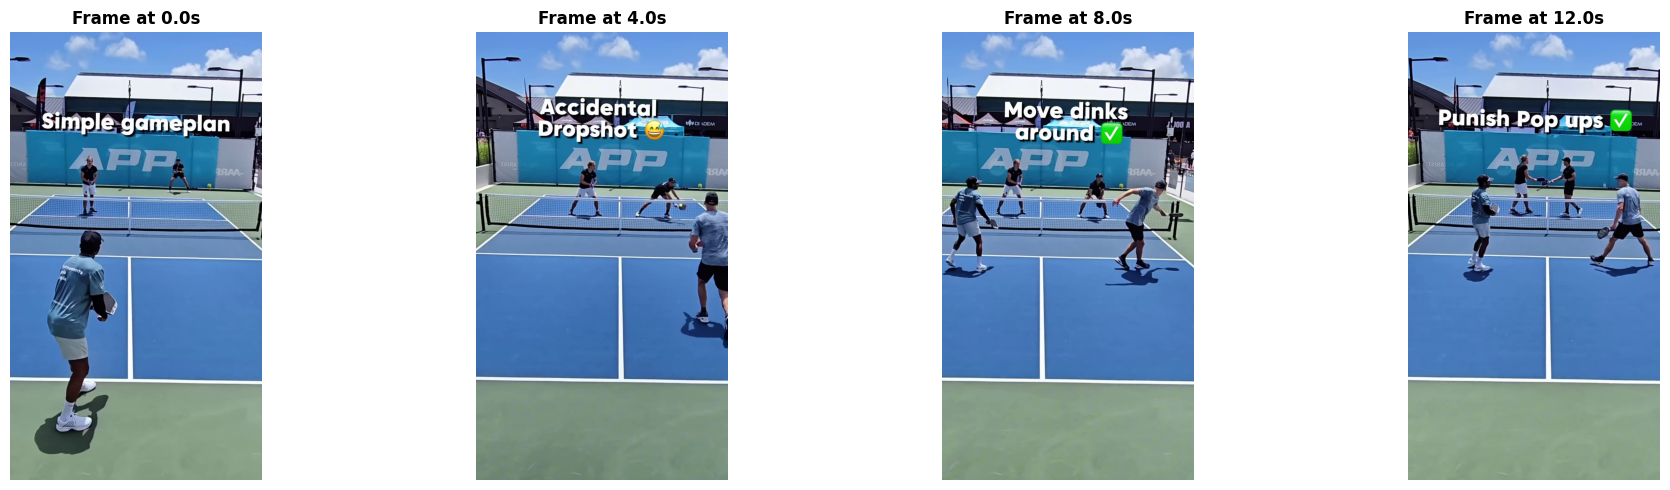

In [6]:
def extract_frames_at_interval(video_path, interval_seconds=4):
    """
    Extract frames at regular intervals from video.

    Args:
        video_path: Path to video file
        interval_seconds: Extract frame every N seconds

    Returns:
        List of (timestamp, PIL Image) tuples
    """
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = total_frames / fps

    print(f"Video info: {fps:.2f} fps, {total_frames} frames, {duration:.2f}s duration")
    print(f"Extracting frames every {interval_seconds} seconds\n")

    # Calculate timestamps
    timestamps = []
    current_time = 0
    while current_time <= duration:
        timestamps.append(current_time)
        current_time += interval_seconds

    # If last timestamp isn't at the end, add end frame
    if timestamps[-1] < duration - 0.1:
        timestamps.append(duration - 0.1)

    frames_data = []
    for time_sec in timestamps:
        frame_number = int(time_sec * fps)
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
        success, frame = cap.read()

        if success:
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            pil_image = Image.fromarray(frame_rgb)
            frames_data.append((time_sec, pil_image))
            print(f"✓ Extracted frame at {time_sec:.2f}s (frame {frame_number})")
        else:
            print(f"✗ Failed to extract frame at {time_sec:.2f}s")

    cap.release()
    return frames_data

# Extract frames every 4 seconds
frames_data = extract_frames_at_interval('video.mp4', interval_seconds=4)

print(f"\n📊 Extracted {len(frames_data)} frames total")
print(f"📹 Will generate {len(frames_data) - 1} clips")

# Save original frames
for i, (timestamp, frame) in enumerate(frames_data):
    frame.save(f'frame_{i}_original.png')

# Display all extracted frames
n_frames = len(frames_data)
fig, axes = plt.subplots(1, n_frames, figsize=(5*n_frames, 5))
if n_frames == 1:
    axes = [axes]
for i, (timestamp, frame) in enumerate(frames_data):
    axes[i].imshow(frame)
    axes[i].set_title(f'Frame at {timestamp:.1f}s', fontsize=12, fontweight='bold')
    axes[i].axis('off')
plt.tight_layout()
plt.show()

## Step 3: Extract Structured JSON Description

In [7]:
model = genai.GenerativeModel('gemini-2.5-flash-lite')

json_prompt = """Analyze this video and return a JSON structure describing it for animation generation.

IMPORTANT: Return ONLY valid JSON, no markdown code blocks or extra text.

Use this exact structure:
{
  "style": {
    "animation_type": "string (e.g., Pixar 3D, Disney 2D, stop-motion)",
    "color_palette": "string describing colors",
    "mood": "string describing tone/feeling"
  },
  "scene": {
    "setting": "string describing location",
    "lighting": "string describing light quality",
    "camera": "string describing camera angles/movement"
  },
  "characters": [
    {
      "species": "animated animal species",
      "appearance": "physical description and clothing",
      "personality": "character traits shown"
    }
  ],
  "audio_cues": [
    "list of important sounds or dialogue"
  ]
}

Requirements:
- Replace all humans with appropriate animated animal characters
- Keep the same actions and energy
- Make it suitable for Pixar/Disney style animation
- Return ONLY the JSON, nothing else
"""

response = model.generate_content([json_prompt, video_file])
response_text = response.text.strip()

# Clean up response
if response_text.startswith('```json'):
    response_text = response_text.replace('```json', '').replace('```', '').strip()
elif response_text.startswith('```'):
    response_text = response_text.replace('```', '').strip()

try:
    video_json = json.loads(response_text)
    print("✅ JSON parsed successfully!\n")
    print(json.dumps(video_json, indent=2))
except json.JSONDecodeError as e:
    print(f"❌ JSON parsing failed: {e}")
    print("Attempting to fix...")
    import re
    json_match = re.search(r'\{.*\}', response_text, re.DOTALL)
    if json_match:
        video_json = json.loads(json_match.group())
        print("✅ JSON extracted and parsed!\n")
        print(json.dumps(video_json, indent=2))
    else:
        raise

✅ JSON parsed successfully!

{
  "style": {
    "animation_type": "Pixar 3D",
    "color_palette": "Bright blues, greens, white, and clear sky with fluffy clouds.",
    "mood": "Energetic, competitive, friendly, and slightly humorous."
  },
  "scene": {
    "setting": "An outdoor pickleball court with a bright blue surface, green perimeter, and a net. There are spectators and sponsor banners in the background.",
    "lighting": "Bright, sunny daylight with clear shadows.",
    "camera": "Dynamic camera angles, starting with a mid-shot of the player in the foreground, often focusing on the action of hitting the ball. Includes some wider shots to show the full court and players, and occasional quick cuts to emphasize hits."
  },
  "characters": [
    {
      "species": "Golden Retriever",
      "appearance": "A golden retriever wearing a light blue athletic t-shirt with text on the back, light-colored athletic shorts, and white athletic shoes. He has a black baseball cap on.",
      "per

## Step 4: Convert ALL Frames to Animated Style

Using Gemini 3 Pro Image to convert each frame to animated style.

In [8]:
# Build character description from JSON
characters_desc = ', '.join([
    f"{c.get('species', 'animal')} wearing {c.get('appearance', 'clothing')}"
    for c in video_json.get('characters', [])
])

# Create prompt for frame conversion
frame_conversion_prompt = f"""
Convert this image to {video_json['style']['animation_type']} style.
Characters: {characters_desc}
Setting: {video_json['scene']['setting']}
Style: {video_json['style']['color_palette']}, {video_json['style']['mood']} mood.
Keep the EXACT same poses, positions, camera angle, and composition.
Maintain all spatial relationships between characters and objects.
"""

print("Conversion prompt:")
print(frame_conversion_prompt)
print("\n" + "="*50 + "\n")

Conversion prompt:

Convert this image to Pixar 3D style.
Characters: Golden Retriever wearing A golden retriever wearing a light blue athletic t-shirt with text on the back, light-colored athletic shorts, and white athletic shoes. He has a black baseball cap on., Border Collie wearing A border collie wearing a black athletic t-shirt, black athletic shorts, and white athletic shoes. He has a black baseball cap on., Beagle wearing A beagle wearing a black athletic t-shirt, dark athletic shorts, and white athletic shoes. He has a black baseball cap on., French Bulldog wearing A french bulldog wearing a white athletic t-shirt, black athletic shorts, and white athletic shoes.
Setting: An outdoor pickleball court with a bright blue surface, green perimeter, and a net. There are spectators and sponsor banners in the background.
Style: Bright blues, greens, white, and clear sky with fluffy clouds., Energetic, competitive, friendly, and slightly humorous. mood.
Keep the EXACT same poses, posit

In [19]:
print(f"Converting {len(frames_data)} frames to animated style...\n")

animated_frames = []

for i, (timestamp, original_frame) in enumerate(frames_data):
    print(f"Converting frame {i+1}/{len(frames_data)} at {timestamp:.1f}s...")

    response = client.models.generate_content(
        model='gemini-3-pro-image-preview',
        contents=[frame_conversion_prompt, original_frame],
        config=types.GenerateContentConfig(
            response_modalities=['IMAGE'],
            image_config=types.ImageConfig(
                aspect_ratio='16:9',
                image_size='2K'
            )
        )
    )

    # Extract the generated image
    for part in response.parts:
        if part.inline_data is not None:
            animated_image = part.as_image()
            animated_image.save(f'frame_{i}_animated.png')
            animated_frames.append((timestamp, animated_image))
            print(f"✅ Frame {i+1} animated\n")
            break

    # Sleep to avoid rate limits (wait 75 seconds between frames)
    if i < len(frames_data) - 1:  # Don't sleep after last frame
        print("⏳ Waiting 75 seconds to avoid rate limits...")
        time.sleep(75)

print(f"\n🎨 All {len(animated_frames)} frames converted!")

Converting 4 frames to animated style...

Converting frame 1/4 at 0.0s...
✅ Frame 1 animated

⏳ Waiting 75 seconds to avoid rate limits...
Converting frame 2/4 at 4.0s...
✅ Frame 2 animated

⏳ Waiting 75 seconds to avoid rate limits...
Converting frame 3/4 at 8.0s...
✅ Frame 3 animated

⏳ Waiting 75 seconds to avoid rate limits...
Converting frame 4/4 at 12.0s...


ClientError: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. \n* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 0, model: gemini-3-pro-image\n* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 0, model: gemini-3-pro-image\n* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_input_token_count, limit: 0, model: gemini-3-pro-image\nPlease retry in 38.354343505s.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.dev/gemini-api/docs/rate-limits'}]}, {'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerDayPerProjectPerModel-FreeTier', 'quotaDimensions': {'model': 'gemini-3-pro-image', 'location': 'global'}}, {'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerMinutePerProjectPerModel-FreeTier', 'quotaDimensions': {'location': 'global', 'model': 'gemini-3-pro-image'}}, {'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_input_token_count', 'quotaId': 'GenerateContentInputTokensPerModelPerMinute-FreeTier', 'quotaDimensions': {'location': 'global', 'model': 'gemini-3-pro-image'}}]}, {'@type': 'type.googleapis.com/google.rpc.RetryInfo', 'retryDelay': '38s'}]}}

## Step 5: Generate Video Clips

Generate 4-second clips between each pair of animated frames.

In [20]:
def json_to_prompt(video_json):
    """Convert structured JSON to a video generation prompt"""
    style = video_json.get('style', {})
    scene = video_json.get('scene', {})
    characters = video_json.get('characters', [])

    style_desc = f"{style.get('animation_type', 'Animated')} with {style.get('color_palette', 'vibrant colors')}. {style.get('mood', 'Energetic')} mood."
    scene_desc = f"Scene: {scene.get('setting', 'outdoor setting')} with {scene.get('lighting', 'natural lighting')}. Camera: {scene.get('camera', 'dynamic angles')}."
    char_desc = "Characters: " + ", ".join([
        f"{c.get('species', 'animal')} ({c.get('appearance', 'colorful')})"
        for c in characters
    ])

    return f"{style_desc} {scene_desc} {char_desc}"

base_prompt = json_to_prompt(video_json)
print("Base prompt for video generation:")
print("="*50)
print(base_prompt)
print("="*50)

Base prompt for video generation:
Pixar 3D with Bright blues, greens, white, and clear sky with fluffy clouds.. Energetic, competitive, friendly, and slightly humorous. mood. Scene: An outdoor pickleball court with a bright blue surface, green perimeter, and a net. There are spectators and sponsor banners in the background. with Bright, sunny daylight with clear shadows.. Camera: Dynamic camera angles, starting with a mid-shot of the player in the foreground, often focusing on the action of hitting the ball. Includes some wider shots to show the full court and players, and occasional quick cuts to emphasize hits.. Characters: Golden Retriever (A golden retriever wearing a light blue athletic t-shirt with text on the back, light-colored athletic shorts, and white athletic shoes. He has a black baseball cap on.), Border Collie (A border collie wearing a black athletic t-shirt, black athletic shorts, and white athletic shoes. He has a black baseball cap on.), Beagle (A beagle wearing a bl

In [24]:
print(f"\nGenerating {len(animated_frames) - 1} video clips...\n")

generated_clips = []

for i in range(len(animated_frames) - 1):
    start_time, start_frame = animated_frames[i]
    end_time, end_frame = animated_frames[i + 1]
    duration = end_time - start_time

    print(f"Clip {i+1}: {start_time:.1f}s → {end_time:.1f}s (target duration: {duration:.1f}s)")

    # Read frames as bytes
    with open(f'frame_{i}_animated.png', 'rb') as f:
        start_bytes = f.read()
    with open(f'frame_{i+1}_animated.png', 'rb') as f:
        end_bytes = f.read()

    # Create Image objects
    start_image_obj = types.Image(
        image_bytes=start_bytes,
        mime_type="image/png"
    )
    end_image_obj = types.Image(
        image_bytes=end_bytes,
        mime_type="image/png"
    )

    # Generate clip (will be 8 seconds by default)
    operation = client.models.generate_videos(
        model="veo-3.1-generate-preview",
        prompt=base_prompt,
        image=start_image_obj,
        config=types.GenerateVideosConfig(
            last_frame=end_image_obj,
            number_of_videos=1,
            resolution="720p"
        )
    )

    # Wait for completion
    while not operation.done:
        print("  Waiting...")
        time.sleep(10)
        operation = client.operations.get(operation)

    # Download clip
    generated_video = operation.response.generated_videos[0]
    client.files.download(file=generated_video.video)
    clip_filename_full = f"clip_{i}_full.mp4"
    generated_video.video.save(clip_filename_full)
    print(f"✅ Clip {i+1} generated (8s)\n")

    # Trim to target duration
    clip_filename = f"clip_{i}.mp4"
    trim_cmd = [
        'ffmpeg',
        '-i', clip_filename_full,
        '-t', str(duration),  # Trim to actual duration needed
        '-c', 'copy',  # Copy without re-encoding (fast)
        clip_filename,
        '-y'
    ]

    result = subprocess.run(trim_cmd, capture_output=True, text=True)
    if result.returncode == 0:
        print(f"✅ Trimmed to {duration:.1f}s → {clip_filename}\n")
        generated_clips.append(clip_filename)
        # Clean up full clip
        os.remove(clip_filename_full)
    else:
        print(f"⚠️  Trim failed, using full clip: {result.stderr}")
        os.rename(clip_filename_full, clip_filename)
        generated_clips.append(clip_filename)

print(f"\n🎬 All {len(generated_clips)} clips generated and trimmed!")


Generating 2 video clips...

Clip 1: 0.0s → 4.0s (target duration: 4.0s)
  Waiting...
  Waiting...
  Waiting...
  Waiting...
  Waiting...
✅ Clip 1 generated (8s)

✅ Trimmed to 4.0s → clip_0.mp4

Clip 2: 4.0s → 8.0s (target duration: 4.0s)
  Waiting...
  Waiting...
  Waiting...
  Waiting...
  Waiting...
  Waiting...
✅ Clip 2 generated (8s)

✅ Trimmed to 4.0s → clip_1.mp4


🎬 All 2 clips generated and trimmed!


## Step 6: Stitch Clips Together

Use ffmpeg to concatenate all clips into the final video.

In [25]:
print("Stitching clips together...\n")

# Create file list for ffmpeg
with open('clips_list.txt', 'w') as f:
    for clip in generated_clips:
        f.write(f"file '{clip}'\n")

# Use ffmpeg to concatenate
output_filename = "iteration3b_output.mp4"
cmd = [
    'ffmpeg',
    '-f', 'concat',
    '-safe', '0',
    '-i', 'clips_list.txt',
    '-c', 'copy',
    output_filename,
    '-y'  # Overwrite output file if exists
]

result = subprocess.run(cmd, capture_output=True, text=True)

if result.returncode == 0:
    print(f"✅ Final video saved to {output_filename}")
else:
    print(f"❌ ffmpeg error: {result.stderr}")
    # Try alternative method with re-encoding
    print("\nTrying alternative method with re-encoding...")
    cmd = [
        'ffmpeg',
        '-f', 'concat',
        '-safe', '0',
        '-i', 'clips_list.txt',
        '-c:v', 'libx264',
        '-preset', 'fast',
        '-crf', '23',
        output_filename,
        '-y'
    ]
    result = subprocess.run(cmd, capture_output=True, text=True)
    if result.returncode == 0:
        print(f"✅ Final video saved to {output_filename}")
    else:
        print(f"❌ Still failed: {result.stderr}")

Stitching clips together...

✅ Final video saved to iteration3b_output.mp4


## Analysis Notes

**What to look for:**
- Smoother transitions at 4-second intervals
- Better pose preservation throughout
- Any visible seams between clips
- Character consistency across clips

**Next steps:**
- If seams are noticeable, try 2-second clips (Iteration 3a)
- If quality is good, consider optimizing cost by using fewer keyframes
- Add audio processing in Iteration 4